# Experiments in Modeling Token Frequency in Texts as Wave Signals

## Load Libraries and Utility Functions

In [1]:
import os
from minineedle import core, needle
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
import pywt
import matplotlib.pyplot as plt
console = Console()
import sys

sys.path.append("..")
from scripts.utils import read_csv_file, set_data_directory_path, get_data_directory_path, generate_table, process_tokens

In [2]:
set_data_directory_path('/Users/zleblanc/Informing-The-Third-World/periodical-collection-curation')

Informing the Third World data directory path set to 
/Users/zleblanc/Informing-The-Third-World/periodical-collection-curation

In [3]:
data_directory_path = get_data_directory_path()
preidentified_periodicals_df = read_csv_file(os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", "periodical_metadata", "classified_preidentified_periodicals_with_full_metadata.csv"))

In [4]:
matching_files = []
for directory, _, files in tqdm(os.walk(f"{data_directory_path}/annotated-HT-pcc-datasets/datasets/annotated_ht_ef_datasets/"), desc="Counting matching files"):
	for file in files:
		if file.endswith(".csv") and 'individual' in file:
			if os.path.exists(os.path.join(directory, file)):
				publication_name = directory.split("/")[-2]
				volume_number = directory.split("/")[-1]
				matching_files.append({"file": file, "directory": directory, "file_path": os.path.join(directory, file), "periodical_title": publication_name, "volume_directory": volume_number})
matching_files_df = pd.DataFrame(matching_files)
console.print(f"Found {len(matching_files_df)} matching files.", style="bright_green")

Counting matching files: 108it [00:00, 37526.70it/s]


Found 85 matching files.

In [5]:
# file_path = matching_files_df[matching_files_df.volume_directory.str.contains("053")]['file_path'].values[0]
data = preidentified_periodicals_df[preidentified_periodicals_df.htid == "mdp.39015056038220"]
publication_directory = data.publication_directory.values[0]
volume_directory = data.volume_directory.values[0]
file_path = os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", publication_directory, "volumes", volume_directory, volume_directory + "_individual_tokens.csv")
preidentified_periodical = False
# file_path = matching_files_df[matching_files_df.periodical_title.str.contains("observer")].file_path.values[0]
# preidentified_periodical = True

### Explore PYWT Built-in Wavelet Families


In [6]:
# Get lists of DWT and CWT wavelets
dwt_wavelets = set(pywt.wavelist(kind='discrete'))
cwt_wavelets = set(pywt.wavelist(kind='continuous'))

# Create a dictionary mapping short family names to full names
family_name_mapping = dict(zip(pywt.families(), pywt.families(short=False)))
# Prepare data for DWT and CWT families
markdown_data = []
# Print DWT families with full names
console.print("[bold cyan]Discrete Wavelet Transform (DWT) Families:[/bold cyan]")
for family in pywt.families():
    wavelets_in_family = pywt.wavelist(family)
    dwt_family_wavelets = [wavelet for wavelet in wavelets_in_family if wavelet in dwt_wavelets]
    if dwt_family_wavelets:
        full_family_name = family_name_mapping[family]
        markdown_data.append({
            "Wavelet Transform": "Discrete (DWT)",
            "Family Name": full_family_name,
            "Short Name": family,
            "Wavelets": ', '.join(dwt_family_wavelets)
        })
        console.print(f"[cyan]{full_family_name} ([/cyan][bright_cyan]{family}[/bright_cyan][cyan]):[/cyan] {', '.join(dwt_family_wavelets)}")

# Print CWT families with full names
console.print("\n[bold magenta]Continuous Wavelet Transform (CWT) Families:[/bold magenta]")
for family in pywt.families():
    wavelets_in_family = pywt.wavelist(family)
    cwt_family_wavelets = [wavelet for wavelet in wavelets_in_family if wavelet in cwt_wavelets]
    if cwt_family_wavelets:
        full_family_name = family_name_mapping[family]
        markdown_data.append({
            "Wavelet Transform": "Continuous (CWT)",
            "Family Name": full_family_name,
            "Short Name": family,
            "Wavelets": ', '.join(cwt_family_wavelets)
        })
        console.print(f"[magenta]{full_family_name} ([/magenta][bright_magenta]{family}[/bright_magenta][magenta]):[/magenta] {', '.join(cwt_family_wavelets)}")

# Optionally, print modes
console.print(f"\n[bright_magenta]Available pywt Modes:[/bright_magenta] {pywt.Modes.modes}")

# Convert to DataFrame for Markdown formatting
markdown_df = pd.DataFrame(markdown_data)

# Generate Markdown Table
markdown_table = markdown_df.to_markdown(index=False)


Discrete Wavelet Transform (DWT) Families:

Haar (haar): haar

Daubechies (db): db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18,
db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, 
db38

Symlets (sym): sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, 
sym17, sym18, sym19, sym20

Coiflets (coif): coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, 
coif14, coif15, coif16, coif17

Biorthogonal (bior): bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, 
bior3.7, bior3.9, bior4.4, bior5.5, bior6.8

Reverse biorthogonal (rbio): rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, 
rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8

Discrete Meyer (FIR Approximation) (dmey): dmey

Continuous Wavelet Transform (CWT) Families:

Gaussian (gaus): gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8

Mexican hat wavelet (mexh): mexh

Morlet wavelet (morl): morl

Complex Gaussian wavelets (cgau): cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, cgau8

Shannon wavelets (shan): shan

Frequency B-Spline wavelets (fbsp): fbsp

Complex Morlet wavelets (cmor): cmor

Available pywt Modes: ['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 
'antisymmetric', 'antireflect']

## Analyze the Waveforms of the Volume Data

In [7]:
merged_df, grouped_df, tokens_raw_signal, tokens_smoothed_signal = process_tokens(file_path, preidentified_periodical, False, False)

Volume has this many tokens: 270910

Expanded volume has this many tokens: 546196

Number of digits in this volume: 5962

Number of non-digit pages in this volume: 123

Number of digits in this volume after filtering for max page length: 5962

Number of pages without digits in this volume after filtering for max page length: 0

Number of pages after including non-digit pages: 919

Calculating digits per page: 100%|██████████| 919/919 [00:00<00:00, 20936.32it/s]


                                               Token and Digit Data                                                
┏━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Pag… ┃ Tokens… ┃ Smoothed tokens … ┃ Standardized tokens… ┃ Digits … ┃ Smoothed digits… ┃ Standardized digits … ┃
┡━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1.0  │   2.0   │        0.0        │ -2.2501172294701575  │   0.0    │       0.0        │  -0.9574361460352875  │
│ 2.0  │  22.0   │        0.0        │ -2.2501172294701575  │   4.0    │       0.0        │  -0.9574361460352875  │
└──────┴─────────┴───────────────────┴──────────────────────┴──────────┴──────────────────┴───────────────────────┘

Replaced 0 missing values in 'tokens_per_page' and 0 missing values in 'digits_per_page' with 0.

Raw Signal Length: 919

Smoothed Signal Length: 919

Likely issue length from tokens autocorrelation: 1

Dominant Frequency: 0.036996735582154515

Number of pages marked as likely covers: 205

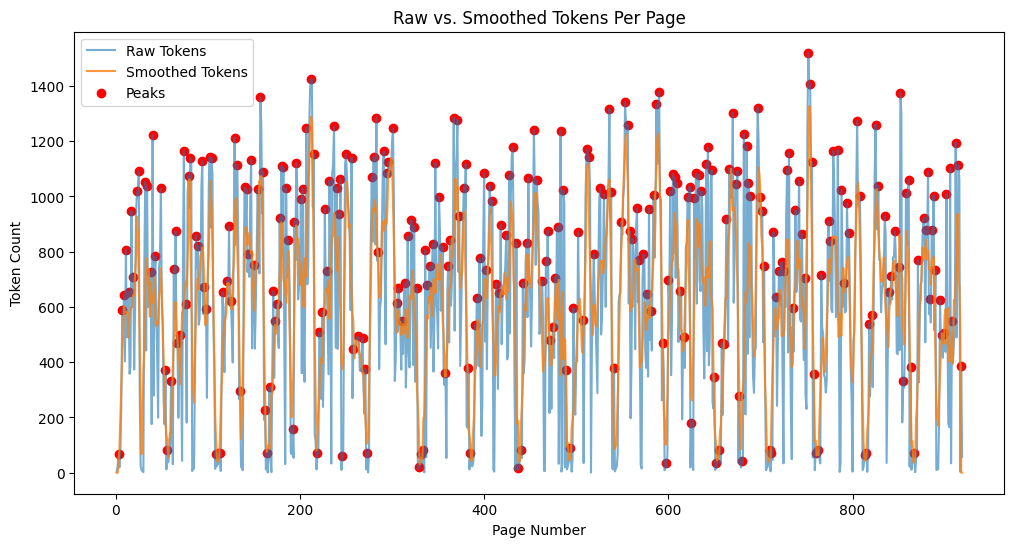

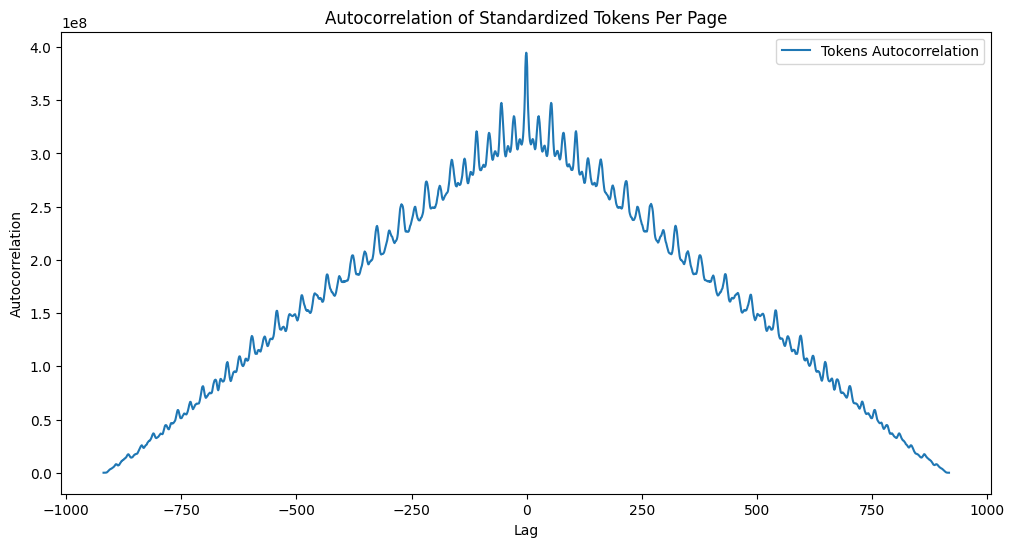

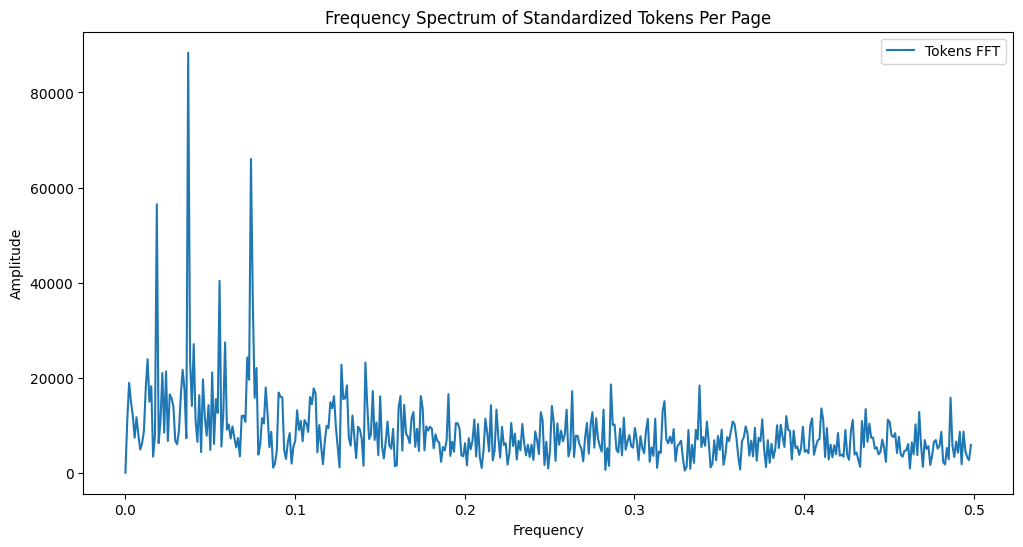

Volume Features:
{
    'avg_tokens': 594.3373231773667,
    'dominant_frequency': 0.036996735582154515,
    'issue_length': 1,
    'htid': 'mdp.39015056038220',
    'periodical_name': 'arab_observer_and_the_scribe'
}

In [8]:

# --- Autocorrelation Analysis for Issue Length ---
tokens_autocorr = np.correlate(tokens_raw_signal, tokens_smoothed_signal, mode='full')

# Find dominant lag (likely issue length)
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr) // 2 + 1:]) + 1
console.print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}", style="bright_green")

# --- Peak Detection (Standardized Tokens) ---
token_peaks, _ = find_peaks(tokens_raw_signal, height=0.5)
merged_df['is_token_peak'] = 0
merged_df.loc[token_peaks, 'is_token_peak'] = 1

# --- FFT for Frequency Analysis ---
tokens_fft_input = tokens_raw_signal - np.mean(tokens_raw_signal)
tokens_fft = fft(tokens_fft_input)
frequencies = np.fft.fftfreq(len(tokens_fft))

dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
dominant_frequency = abs(frequencies[dominant_frequency_index])
console.print(f"Dominant Frequency: {dominant_frequency}", style="bright_green")

# Detect likely covers based on low standardized tokens and digits
merged_df['is_likely_cover'] = (
    (merged_df['standardized_tokens_per_page'] < -0.5) &  # Threshold for low token counts
    (merged_df['standardized_digits_per_page'] < -0.5)    # Threshold for low digit counts
)

# Summary of likely covers
num_covers = merged_df['is_likely_cover'].sum()
console.print(f"Number of pages marked as likely covers: {num_covers}", style="bright_green")

# --- Visualization ---
# Raw vs Smoothed Tokens
plt.figure(figsize=(12, 6))
plt.plot(merged_df['page_number'], merged_df['tokens_per_page'], label='Raw Tokens', alpha=0.6)
plt.plot(merged_df['page_number'], merged_df['smoothed_tokens_per_page'], label='Smoothed Tokens', alpha=0.8)
plt.scatter(merged_df['page_number'].iloc[token_peaks], merged_df['tokens_per_page'].iloc[token_peaks], color='red', label='Peaks')
plt.title("Raw vs. Smoothed Tokens Per Page")
plt.xlabel("Page Number")
plt.ylabel("Token Count")
plt.legend()
plt.show()

# Autocorrelation Plot
lags = np.arange(-len(tokens_autocorr) // 2, len(tokens_autocorr) // 2)
plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Autocorrelation')
plt.title("Autocorrelation of Standardized Tokens Per Page")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# Frequency Analysis Plot
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens FFT')
plt.title("Frequency Spectrum of Standardized Tokens Per Page")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# --- Aggregated Features ---
volume_features = {
    'avg_tokens': merged_df['tokens_per_page'].mean(),
    'dominant_frequency': dominant_frequency,
    'issue_length': tokens_autocorr_lag,
    'htid': merged_df['htid'].unique()[0],
    'periodical_name': merged_df['periodical_name'].unique()[0]
}

console.print("Volume Features:", volume_features)

In [9]:
wavelet = "bior1.3"
level = 1
mode = "zero"
signal = tokens_raw_signal
coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
reconstructed_signal = pywt.waverec(coeffs, wavelet, mode=mode)[:len(signal)]

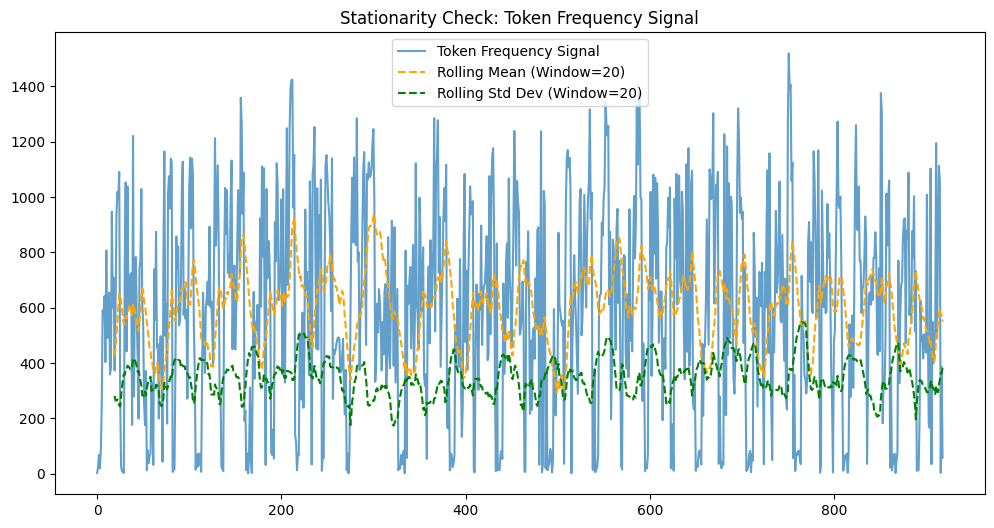

In [10]:
# Example: token_signal is the signal array
signal_df = pd.DataFrame({'tokens': tokens_raw_signal})
signal_df['rolling_mean'] = signal_df['tokens'].rolling(window=20).mean()
signal_df['rolling_std'] = signal_df['tokens'].rolling(window=20).std()

plt.figure(figsize=(12, 6))
plt.plot(signal_df['tokens'], label='Token Frequency Signal', alpha=0.7)
plt.plot(signal_df['rolling_mean'], label='Rolling Mean (Window=20)', linestyle='--', color='orange')
plt.plot(signal_df['rolling_std'], label='Rolling Std Dev (Window=20)', linestyle='--', color='green')
plt.legend()
plt.title("Stationarity Check: Token Frequency Signal")
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
adf_test = adfuller(tokens_raw_signal)
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# KPSS Test
kpss_test = kpss(tokens_raw_signal, regression='c')
print(f"KPSS Statistic: {kpss_test[0]}, p-value: {kpss_test[1]}")

ADF Statistic: -10.733524832162134, p-value: 2.938381375774256e-19
KPSS Statistic: 0.04737642064445683, p-value: 0.1


/Users/zleblanc/.virtualenvs/htrc-periodicals-venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


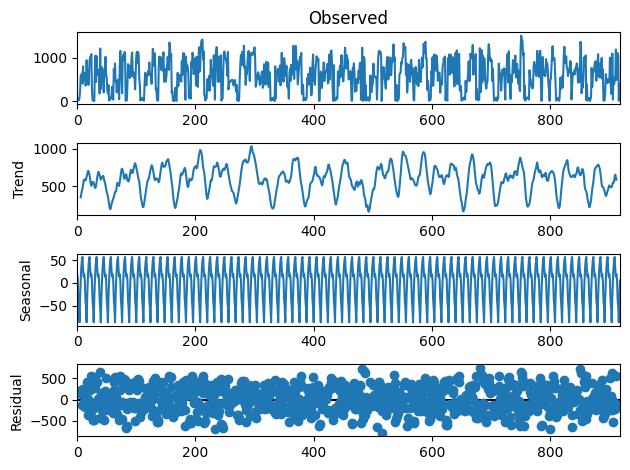

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(tokens_raw_signal, model='additive', period=12)
result.plot()
plt.show()

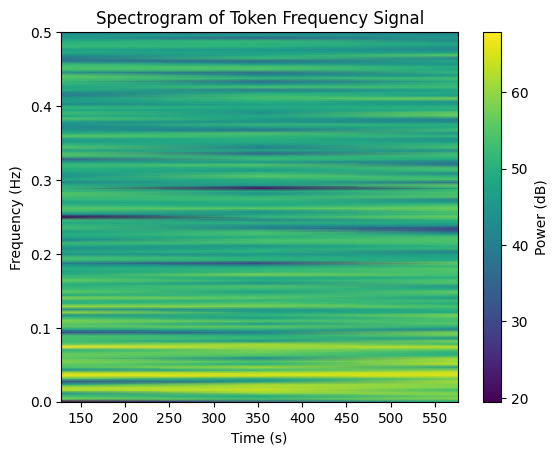

In [13]:
from scipy.signal import spectrogram

frequencies, times, Sxx = spectrogram(tokens_raw_signal, fs=1)  # Assume unit sampling rate
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of Token Frequency Signal')
plt.colorbar(label='Power (dB)')
plt.show()

In [14]:
def energy_entropy_ratio(coeffs):
	"""
	Compute energy-to-entropy ratio for wavelet coefficients.

	Parameters:
	-----------
	coeffs : np.ndarray
		Wavelet coefficients (can be complex).

	Returns:
	--------
	ratio : float
		Energy-to-entropy ratio.
	"""
	# Use absolute values of coefficients for energy and entropy computation
	magnitudes = np.abs(coeffs)
	total_energy = np.sum(magnitudes ** 2)
	entropy = -np.sum(
		(magnitudes ** 2 / total_energy) * np.log2(magnitudes ** 2 / total_energy + 1e-12)
	)  # Add a small constant to avoid log(0)
	return total_energy / (entropy if entropy > 0 else 1e-12)  # Avoid division by zero


def sparsity_measure(coeffs: list, threshold: float = 1e-2) -> float:
    """
    Measure sparsity of wavelet coefficients.

    Parameters:
    -----------
    coeffs : list of np.ndarray
        Wavelet decomposition coefficients.
    threshold : float, optional
        Threshold for near-zero coefficients.

    Returns:
    --------
    sparsity : float
        Percentage of near-zero coefficients.
    """
    total_coeffs = np.abs(np.concatenate(coeffs))
    
    # Normalize coefficients to scale values between 0 and 1
    normalized_coeffs = total_coeffs / (np.max(total_coeffs) if np.max(total_coeffs) > 0 else 1)
    
    # Compute sparsity as percentage of near-zero coefficients
    sparsity = np.sum(normalized_coeffs < threshold) / len(normalized_coeffs)
    
    # Debugging info
    # console.print(f"Threshold: {threshold}, Near-zero coefficients: {np.sum(normalized_coeffs < threshold)}, Total coefficients: {len(normalized_coeffs)}", style="bright_yellow")
    
    return sparsity
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr
# Evaluate Wavelet Performance (DWT)
def evaluate_dwt_performance(signal, wavelets, modes, signal_type):
	results = []
	skipped_wavelets = []
	for wavelet in tqdm(wavelets, desc=f"Testing DWT Wavelets for {signal_type}"):
		try:
			wavelet_filter_len = pywt.Wavelet(wavelet).dec_len
			if len(signal) < wavelet_filter_len:
				raise ValueError(f"Signal is too short for wavelet {wavelet}")

			max_level = pywt.dwt_max_level(len(signal), filter_len=wavelet_filter_len)
			for level in range(1, max_level + 1):
				for mode in modes:
					try:
						# Decompose signal
						coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
						# Check if all coefficient lengths are consistent
						coeff_shapes = [len(c) for c in coeffs]
						if len(set(coeff_shapes)) > 1:
							skipped_wavelets.append({'wavelet': wavelet, 'level': level, 'mode': mode, 'coeff_shapes': coeff_shapes, 'error': "Inconsistent coefficient lengths", 'signal_length': len(signal), 'signal_type': signal_type})
							continue
						# Reconstruct signal
						reconstructed_signal = pywt.waverec(coeffs, wavelet, mode=mode)[:len(signal)]

						# Compute Metrics
						mse = np.mean((signal - reconstructed_signal) ** 2)
						energy_entropy = energy_entropy_ratio(coeffs)
						sparsity = sparsity_measure(coeffs)
						emd_value = wasserstein_distance(signal, reconstructed_signal)
						kl_div_value = sum(rel_entr(signal, reconstructed_signal + 1e-12))
						# Append Results
						results.append({
							'signal_type': signal_type,
							'wavelet': wavelet,
							'wavelet_level': level,
							'wavelet_mode': mode,
							'wavelet_mse': mse,
							'wavelet_energy_entropy': energy_entropy,
							'wavelet_sparsity': sparsity,
							'emd': emd_value,
							'kl_div': kl_div_value
						})
					except ValueError as e:
						# print(f"Skipping wavelet {wavelet}, level {level}, mode {mode}: {e}")
						skipped_wavelets.append({'wavelet': wavelet, 'level': level, 'mode': mode, 'error': str(e), 'signal_length': len(signal), 'signal_type': signal_type})
		except Exception as e:
			# print(f"Error testing wavelet {wavelet}: {e}")
			skipped_wavelets.append({'wavelet': wavelet, 'level': None, 'mode': None, 'error': str(e), 'signal_length': len(signal), 'signal_type': signal_type})
	skipped_wavelets_df = pd.DataFrame(skipped_wavelets)
	console.print(f"Skipped wavelets: {len(skipped_wavelets_df)}", style="bright_red")
	total_results = pd.DataFrame(results)
	console.print(f"Total DWT results: {len(total_results)}", style="bright_green")
	return total_results, skipped_wavelets_df


# Evaluate Wavelet Performance (CWT)
def evaluate_cwt_performance(signal, wavelets, signal_type, scales):
	results = []
	for wavelet in tqdm(wavelets, desc=f"Testing CWT Wavelets for {signal_type}"):
		try:
			# Perform Continuous Wavelet Transform
			coeffs, frequencies = pywt.cwt(signal, scales=scales, wavelet=wavelet)
			# Compute Metrics
			total_energy = np.sum(coeffs ** 2)
			entropy = -np.sum(coeffs ** 2 / total_energy * np.log2(coeffs ** 2 / total_energy), axis=None)
			energy_entropy = total_energy / entropy if entropy > 0 else np.inf
			sparsity = np.sum(np.abs(coeffs) < 1e-3) / coeffs.size

			# Append Results
			results.append({
				'signal_type': signal_type,
				'wavelet': wavelet,
				'wavelet_energy_entropy': energy_entropy,
				'wavelet_sparsity': sparsity
			})
		except Exception as e:
			print(f"Error testing wavelet {wavelet}: {e}")
	total_results = pd.DataFrame(results)
	
	metrics = ['wavelet_energy_entropy', 'wavelet_sparsity']
	subset_results = total_results.replace([np.inf, -np.inf], np.nan).dropna(subset=metrics).reset_index(drop=True)
	console.print(f"Total CWT results: {len(subset_results)}", style="bright_green")
	skipped_results = total_results[~total_results.index.isin(subset_results.index)]
	console.print(f"Skipped CWT results: {len(skipped_results)}", style="bright_red")
	return total_results, skipped_results


# Parameters
weights = {'wavelet_mse': 0.5, 'wavelet_energy_entropy': 0.3, 'wavelet_sparsity': 0.2}
dwt_wavelets = pywt.wavelist(kind='discrete')
cwt_wavelets = pywt.wavelist(kind='continuous')
modes = pywt.Modes.modes
scales = np.arange(1, 128)  # Adjustable range of scales for CWT

# Preprocess Signals
raw_signal = np.nan_to_num(merged_df['tokens_per_page'].values, nan=0.0, posinf=0.0, neginf=0.0)
smoothed_signal = np.nan_to_num(merged_df['smoothed_tokens_per_page'].values, nan=0.0, posinf=0.0, neginf=0.0)
console.print(f"Raw Signal Length: {len(raw_signal)}", style="bright_green")
console.print(f"Smoothed Signal Length: {len(smoothed_signal)}", style="bright_green")
# Select appropriate wavelet method based on signal type
# if len(raw_signal) > 500:  # Example threshold for selecting CWT
cwt_raw_results, cwt_raw_skipped_results = evaluate_cwt_performance(raw_signal, cwt_wavelets, 'raw', scales=scales)
cwt_smoothed_results, cwt_smoothed_skipped_results = evaluate_cwt_performance(smoothed_signal, cwt_wavelets, 'smoothed', scales=scales)
combined_cwt_skipped_results = pd.concat([cwt_raw_skipped_results, cwt_smoothed_skipped_results], ignore_index=True)
dwt_raw_results, dwt_raw_skipped_results = evaluate_dwt_performance(raw_signal, dwt_wavelets, modes, 'raw')
dwt_smoothed_results, dwt_smoothed_skipped_results = evaluate_dwt_performance(smoothed_signal, dwt_wavelets, modes, 'smoothed')
combined_dwt_skipped_results = pd.concat([dwt_raw_skipped_results, dwt_smoothed_skipped_results], ignore_index=True)

Raw Signal Length: 919

Smoothed Signal Length: 919

Testing CWT Wavelets for raw: 100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


Total CWT results: 21

Skipped CWT results: 0

Testing CWT Wavelets for smoothed: 100%|██████████| 21/21 [00:01<00:00, 15.24it/s]


Total CWT results: 21

Skipped CWT results: 0

Testing DWT Wavelets for raw: 100%|██████████| 106/106 [00:00<00:00, 168.19it/s]


Skipped wavelets: 3879

Total DWT results: 954

Testing DWT Wavelets for smoothed: 100%|██████████| 106/106 [00:00<00:00, 176.68it/s]


Skipped wavelets: 3879

Total DWT results: 954

In [15]:
def determine_best_wavelet_representation(results_df: pd.DataFrame, signal_type: str, weights: dict = None, is_combined: bool = False) -> tuple:
	"""
	Determine the best wavelet representation based on MSE, Energy-to-Entropy Ratio, and Sparsity within a volume. Normalize and combine scores to rank the results for both normalized and z-scored metrics across DWT and CWT.

	Parameters:
	-----------
	results_df : pd.DataFrame
		DataFrame containing Wavelet metrics.
	signal_type : str
		Type of signal being analyzed (e.g., "DWT" or "CWT").
	weights : dict, optional
		Dictionary of weights for each metric. Example:
		{'MSE': 0.5, 'Energy-to-Entropy': 0.3, 'Sparsity': 0.2}
	is_combined : bool, optional
		Flag indicating whether the results are combined. If True, the prefix 'combined_' is used.

	Returns:
	--------
	best_config : pd.Series
		The row containing the best wavelet, level, and mode.
	ranked_results : pd.DataFrame
		DataFrame with combined scores and rankings.
	correlation_norm_zscore : float
		Correlation between normalized and zscored combined scores. Useful for checking consistency and identifying outliers.
	"""
	console.print(f"Results for {signal_type} Wavelet Analysis")
	# Handle zero variance in sparsity
	if 'wavelet_sparsity' in results_df.columns and results_df['wavelet_sparsity'].nunique() == 1:
		console.print(f"[yellow]Dropping 'wavelet_sparsity' due to zero variance.[/yellow]")
		results_df = results_df.drop(columns=['wavelet_sparsity'])
		weights.pop('wavelet_sparsity', None)
	# Handle extreme values in energy_entropy
	if 'wavelet_energy_entropy' in results_df.columns:
		results_df['wavelet_energy_entropy'] = np.log1p(np.abs(results_df['wavelet_energy_entropy']))
	# Handle complex-valued metrics only
	for column in ['wavelet_energy_entropy']:
		if column in results_df.columns and np.iscomplexobj(results_df[column].values):
			console.print(f"Converting {column} to magnitudes due to complex values.", style="yellow")
			results_df[column] = np.abs(results_df[column])

	# Normalize metrics
	scaler = MinMaxScaler()
	normalized_df = results_df.copy()
	prefix = 'combined_' if is_combined else ''

	# Identify metrics for normalization
	metrics = [col for col in ['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity'] if col in results_df.columns]
	

	# Normalize specified metrics
	normalized_metrics = [f"{prefix}{metric}_norm" for metric in metrics]
	normalized_df[normalized_metrics] = scaler.fit_transform(results_df[metrics])
	if 'wavelet_mse' in results_df.columns:
		normalized_df[f'{prefix}wavelet_mse_norm'] = 1 - normalized_df[f'{prefix}wavelet_mse_norm']  # Lower MSE is better

	# Compute z-score normalization
	zscore_metrics = [f"{prefix}{metric}_zscore" for metric in metrics]
	normalized_df[zscore_metrics] = (
		(normalized_df[metrics] - normalized_df[metrics].mean()) /
		(normalized_df[metrics].std().replace(0, np.nan))  # Avoid division by zero
	)

	# Compute combined scores
	normalized_df[f'{prefix}wavelet_norm_combined_score'] = sum(
		weights.get(metric, 0) * normalized_df.get(f'{prefix}{metric}_norm', 0) 
		for metric in metrics
	)
	normalized_df[f'{prefix}wavelet_zscore_combined_score'] = sum(
		weights.get(metric, 0) * normalized_df.get(f'{prefix}{metric}_zscore', 0) 
		for metric in metrics
	)

	# Rank results
	ranked_results = normalized_df.sort_values(
		by=[f'{prefix}wavelet_norm_combined_score', f'{prefix}wavelet_zscore_combined_score'], 
		ascending=False
	).reset_index(drop=True)
	ranked_results[f'{prefix}wavelet_rank'] = ranked_results.index + 1

	# Calculate correlation between normalized and z-score combined scores
	correlation_norm_zscore = ranked_results[
		[f'{prefix}wavelet_norm_combined_score', f'{prefix}wavelet_zscore_combined_score']
	].corr().iloc[0, 1]

	# Return the best configuration, ranked results, and correlation
	best_config = ranked_results[0:1]
	return best_config, ranked_results, correlation_norm_zscore

def compare_and_rank_wavelet_metrics(raw_signal, smoothed_signal, dwt_wavelets, cwt_wavelets, modes, weights, scales):
	"""
	Compare wavelet metrics for raw and smoothed tokens across DWT and CWT.

	Parameters:
	-----------
	raw_signal : np.ndarray
		Raw tokens per page.
	smoothed_signal : np.ndarray
		Smoothed tokens per page.
	dwt_wavelets : list of str
		List of DWT wavelet names to test.
	cwt_wavelets : list of str
		List of CWT wavelet names to test.
	modes : list of str
		List of signal extension modes to test for DWT.
	weights : dict
		Weights for metrics (e.g., MSE, Energy-to-Entropy, and Sparsity).
	scales : np.ndarray
		Scales to use for CWT.

	Returns:
	--------
	pd.DataFrame
		Combined results across DWT and CWT.
	"""
	# Evaluate metrics for DWT
	dwt_raw_results, dwt_raw_skipped_results = evaluate_dwt_performance(raw_signal, dwt_wavelets, modes, 'raw')
	dwt_smoothed_results, dwt_smoothed_skipped_results = evaluate_dwt_performance(smoothed_signal, dwt_wavelets, modes, 'smoothed')

	# Evaluate metrics for CWT
	cwt_raw_results, cwt_raw_skipped_results = evaluate_cwt_performance(raw_signal, cwt_wavelets, 'raw', scales=scales)
	cwt_smoothed_results, cwt_smoothed_skipped_results = evaluate_cwt_performance(smoothed_signal, cwt_wavelets, 'smoothed', scales=scales)

	# Combine results
	dwt_combined_results = pd.concat([dwt_raw_results, dwt_smoothed_results], ignore_index=True)
	cwt_combined_results = pd.concat([cwt_raw_results, cwt_smoothed_results], ignore_index=True)

	# Determine best representations
	best_dwt, ranked_dwt, dwt_correlation_score = determine_best_wavelet_representation(dwt_combined_results, 'DWT', weights)
	best_cwt, ranked_cwt, cwt_correlation_score = determine_best_wavelet_representation(cwt_combined_results, 'CWT', weights)

	ranked_dwt['wavelet_type'] = 'DWT'
	ranked_cwt['wavelet_type'] = 'CWT'
	# Combine DWT and CWT results
	combined_results = pd.concat([ranked_dwt, ranked_cwt], ignore_index=True)

	# Determine overall best representation
	best_combined_results, ranked_combined_results, combined_correlation_score = determine_best_wavelet_representation(combined_results, 'Combined', weights, is_combined=True)

	# Display results
	if len(best_dwt) > 0:
		generate_table(best_dwt, f"Best DWT Wavelet Configuration (Correlation: {dwt_correlation_score:.2f})")
	if len(best_cwt) > 0:
		generate_table(best_cwt, f"Best CWT Wavelet Configuration (Correlation: {cwt_correlation_score:.2f})")
	if len(best_combined_results) > 0:
		generate_table(best_combined_results, f"Best Combined Wavelet Configuration (Correlation: {combined_correlation_score:.2f})")

	return ranked_combined_results, best_combined_results, ranked_dwt, ranked_cwt

# Compare and Rank Wavelet Metrics
ranked_combined_results, best_combined_results, ranked_dwt, ranked_cwt = compare_and_rank_wavelet_metrics(
	raw_signal, smoothed_signal, dwt_wavelets, cwt_wavelets, modes, weights, scales
)

Testing DWT Wavelets for raw: 100%|██████████| 106/106 [00:00<00:00, 177.45it/s]


Skipped wavelets: 3879

Total DWT results: 954

Testing DWT Wavelets for smoothed: 100%|██████████| 106/106 [00:00<00:00, 207.49it/s]


Skipped wavelets: 3879

Total DWT results: 954

Testing CWT Wavelets for raw: 100%|██████████| 21/21 [00:01<00:00, 14.72it/s]


Total CWT results: 21

Skipped CWT results: 0

Testing CWT Wavelets for smoothed: 100%|██████████| 21/21 [00:01<00:00, 14.10it/s]


Total CWT results: 21

Skipped CWT results: 0

Results for DWT Wavelet Analysis

Results for CWT Wavelet Analysis

Results for Combined Wavelet Analysis

                                 Best DWT Wavelet Configuration (Correlation: -0.23)                               
┏┳┳┳┳━━━━━━┳━━━━━━━┳━━━┳━━━━━━━┳━━━━━━━━┳━┳━━━━━━━━━━━┳━━━━━━┳━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━
┃┃┃┃┃ Wav… ┃ Wave… ┃ … ┃  Emd  ┃ Kl div ┃ ┃ Wavelet … ┃ Wav… ┃ W… ┃ Wavelet ene… ┃ Wave… ┃ Wavelet n… ┃ Wavelet zs…
┡╇╇╇╇━━━━━━╇━━━━━━━╇━━━╇━━━━━━━╇━━━━━━━━╇━╇━━━━━━━━━━━╇━━━━━━╇━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━
│││││ 8.3… │ 19.7… │ … │ 2.07… │ -1.01… │ │    1.0    │ 1.0  │ -… │ 14.97567370… │ 3.23… │    1.0     │ 5.09317480…
└┴┴┴┴──────┴───────┴───┴───────┴────────┴─┴───────────┴──────┴────┴──────────────┴───────┴────────────┴────────────

                                Best CWT Wavelet Configuration (Correlation: 1.00)                                 
┏┳┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳┓
┃┃┃ Wavelet… ┃ Wavele… ┃ Wavelet ener… ┃ Wavele… ┃ Wavelet energy… ┃ Wavelet … ┃ Wavelet norm… ┃ Wavelet zscore… ┃┃
┡╇╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇┩
│││ 21.7903… │ 8.5680… │ 0.8367215741… │   1.0   │ 0.601038666576… │ 3.562369… │ 0.4510164722… │ 0.892785492560… ││
└┴┴──────────┴─────────┴───────────────┴─────────┴─────────────────┴───────────┴───────────────┴─────────────────┴┘

                               Best Combined Wavelet Configuration (Correlation: -0.35)                            
┏┳┳┳┳┳┳┳┳━┳┳━━━━━┳┳┳━━━━━━━┳━┳━━━━━┳━━━━━━━┳┳┳┳━━━━━━━━━━━┳━━━━━┳━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━
┃┃┃┃┃┃┃┃┃ ┃┃ Wa… ┃┃┃ Wave… ┃ ┃ Wa… ┃ Wave… ┃┃┃┃ Combined… ┃ Co… ┃  ┃ Combined w… ┃ Combi… ┃ Combined… ┃ Combined wa
┡╇╇╇╇╇╇╇╇━╇╇━━━━━╇╇╇━━━━━━━╇━╇━━━━━╇━━━━━━━╇╇╇╇━━━━━━━━━━━╇━━━━━╇━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━
│││││││││ ││ 1.0 │││ 14.9… │ │ 1.0 │ 5.09… ││││ 0.727767… │ 1.0 │  │ 3.57867024… │ 3.196… │ 0.918330… │ 1.666567442
└┴┴┴┴┴┴┴┴─┴┴─────┴┴┴───────┴─┴─────┴───────┴┴┴┴───────────┴─────┴──┴─────────────┴────────┴───────────┴────────────

In [16]:
selection = alt.selection_multi(fields=['wavelet'], bind='legend')
alt.Chart(ranked_combined_results).mark_line(point=True).encode(
	x='wavelet_rank',
	y='combined_wavelet_rank',
	color=alt.Color("wavelet", legend=alt.Legend(symbolLimit=0, columns=8)),
	row='wavelet_type:N',
	column='signal_type:N',
	opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
	tooltip=['wavelet', 'wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity', 'wavelet_norm_combined_score', 'combined_wavelet_rank'],
	shape="wavelet_level:N"
).add_params(selection).properties(
	title='Combined Wavelet Performance',
	width=800,
	height=400
).configure_legend(
	orient='bottom'
)

alt.Chart(...)

In [17]:
def calculate_signal_metrics(
    tokens_signal: np.ndarray,
    page_type: str,
    min_tokens: float,
    prominence=1.0,
    distance=5,
    verbose=False
) -> dict:
    """
    Calculate metrics for a given signal, including dominant frequency, dynamic cutoff,
    relative peak detection, autocorrelation, signal envelope, and spectral features.

    Parameters
    ----------
    tokens_signal : np.ndarray
        The signal to be analyzed.
    page_type : str
        The type of page being analyzed (e.g., raw or smoothed "tokens_per_page").
    min_tokens : float
        The minimum observed tokens per page in the original scale.
    prominence : float, optional
        Minimum prominence of peaks for relative detection.
    distance : int, optional
        Minimum distance between peaks for relative detection.
    verbose : bool, optional
        Whether to log detailed metrics for debugging.

    Returns
    -------
    dict
        Results containing signal metrics.
    """
    try:
        # Perform FFT for frequency analysis
        tokens_fft = fft(tokens_signal)
        frequencies = np.fft.fftfreq(len(tokens_fft))

        # Analyze positive frequencies and amplitudes
        positive_frequencies = frequencies[:len(frequencies)//2]
        positive_amplitudes = np.abs(tokens_fft[:len(tokens_fft)//2])

        # Find FFT peaks
        peaks, _ = find_peaks(positive_amplitudes[1:])
        num_peaks = len(peaks)
        peak_amplitude = np.max(positive_amplitudes[1:][peaks]) if num_peaks > 0 else None
        dominant_frequency = (
            positive_frequencies[peaks[np.argmax(positive_amplitudes[1:][peaks])]] 
            if num_peaks > 0 else None
        )

        # Calculate dynamic cutoff
        dynamic_cutoff_signal = (
            max(np.median(tokens_signal) - (peak_amplitude or 0), np.percentile(tokens_signal, 10))
            if num_peaks > 0 else np.percentile(tokens_signal, 10)
        )
        dynamic_cutoff_original_scale = max(dynamic_cutoff_signal, min_tokens)

        # Perform relative peak detection
        prominence = prominence if prominence is not None else np.std(tokens_signal) * 0.1
        distance = distance if distance is not None else max(1, len(tokens_signal) // 20)
        relative_peaks, relative_properties = find_peaks(tokens_signal, prominence=prominence, distance=distance)
        relative_num_peaks = len(relative_peaks)
        avg_prominence = np.mean(relative_properties["prominences"]) if relative_num_peaks > 0 else None

        # Calculate autocorrelation
        autocorr = np.correlate(tokens_signal, tokens_signal, mode='full')
        max_autocorr = np.max(autocorr[len(autocorr)//2:])

        # Signal envelope
        upper_envelope = np.max(np.abs(tokens_signal))
        lower_envelope = -upper_envelope

        # Spectral features
        spectral_magnitude = np.sum(positive_amplitudes)
        spectral_centroid = (
            np.sum(positive_frequencies * positive_amplitudes) / spectral_magnitude 
            if spectral_magnitude > 0 else None
        )
        spectral_bandwidth = (
            np.sqrt(np.sum((positive_frequencies - spectral_centroid) ** 2 * positive_amplitudes) / spectral_magnitude) 
            if spectral_centroid else None
        )

        # Logging (controlled by `verbose`)
        if verbose:
            console.print(f"[bright_cyan]Metrics for {page_type}[/bright_cyan]")
            console.print(f"Dominant Frequency: {dominant_frequency}")
            console.print(f"Dynamic Cutoff: {dynamic_cutoff_original_scale}")
            console.print(f"Number of Peaks: {num_peaks}")
            console.print(f"Peak Amplitude: {peak_amplitude}")
            console.print(f"Relative Peaks: {relative_num_peaks}")
            console.print(f"Average Prominence: {avg_prominence}")
            console.print(f"Max Autocorrelation: {max_autocorr}")
            console.print(f"Spectral Centroid: {spectral_centroid}")
            console.print(f"Spectral Bandwidth: {spectral_bandwidth}")
            console.print(f"Upper Envelope: {upper_envelope}")
            console.print(f"Lower Envelope: {lower_envelope}")
            console.print(f"Spectral Magnitude: {spectral_magnitude}")

        return {
            "signal_type": page_type,
            "dominant_frequency": dominant_frequency,
            "dynamic_cutoff": dynamic_cutoff_original_scale,
            "num_peaks": num_peaks,
            "peak_amplitude": peak_amplitude,
            "relative_num_peaks": relative_num_peaks,
            "avg_prominence": avg_prominence,
            "max_autocorrelation": max_autocorr,
            "upper_envelope": upper_envelope,
            "lower_envelope": lower_envelope,
            "spectral_centroid": spectral_centroid,
            "spectral_bandwidth": spectral_bandwidth,
            "spectral_magnitude": spectral_magnitude,
            "positive_frequencies": positive_frequencies,
			"positive_amplitudes": positive_amplitudes,
        }
    except Exception as e:
        console.print(f"[bright_red]Error calculating metrics for {page_type}: {e}[/bright_red]")
        return {}

# Example usage
signal_types = {
    "raw": merged_df['tokens_per_page'].values,
    "smoothed": merged_df['smoothed_tokens_per_page'].values,
}

# Calculate metrics for each representation
signal_metrics_results = []
for rep_name, signal in signal_types.items():
    result = calculate_signal_metrics(
        tokens_signal=signal,
        page_type=rep_name,
        min_tokens=merged_df['tokens_per_page'].min(),
        prominence=1.0,
        distance=5,
        verbose=True
    )
    signal_metrics_results.append(result)

# Convert to DataFrame for easier analysis
signal_metrics_df = pd.DataFrame(signal_metrics_results)
console.print(signal_metrics_df, style="bright_green")

Metrics for raw

Dominant Frequency: 0.035908596300326445

Dynamic Cutoff: 35.0

Number of Peaks: 161

Peak Amplitude: 88363.9794155054

Relative Peaks: 134

Average Prominence: 632.1268656716418

Max Autocorrelation: 449681218.0

Spectral Centroid: 0.17802074292842454

Spectral Bandwidth: 0.1525813694051669

Upper Envelope: 1520.0

Lower Envelope: -1520.0

Spectral Magnitude: 4420723.747789041

Metrics for smoothed

Dominant Frequency: 0.035908596300326445

Dynamic Cutoff: 190.40000000000003

Number of Peaks: 156

Peak Amplitude: 83811.98494700891

Relative Peaks: 96

Average Prominence: 374.75416666666666

Max Autocorrelation: 387908868.2000002

Spectral Centroid: 0.08051516677478683

Spectral Bandwidth: 0.10846243682947852

Upper Envelope: 1326.8

Lower Envelope: -1326.8

Spectral Magnitude: 2259349.6989631737

  signal_type  dominant_frequency  dynamic_cutoff  num_peaks  peak_amplitude  \
0         raw            0.035909            35.0        161    88363.979416   
1    smoothed            0.035909           190.4        156    83811.984947   

   relative_num_peaks  avg_prominence  max_autocorrelation  upper_envelope  \
0                 134      632.126866          449681218.0          1520.0   
1                  96      374.754167          387908868.2          1326.8   

   lower_envelope  spectral_centroid  spectral_bandwidth  spectral_magnitude  \
0         -1520.0           0.178021            0.152581        4.420724e+06   
1         -1326.8           0.080515            0.108462        2.259350e+06   

                                positive_frequencies  \
0  [0.0, 0.001088139281828074, 0.0021762785636561...   
1  [0.0, 0.001088139281828074, 0.0021762785636561...   

                                 positive_amplitudes  
0  [546196.0, 11065.563139498043, 18907.953167286...  
1  [545659.8, 11596.096797512297, 19427.286375055...  

In [18]:
# Separate raw and smoothed signals
raw_signals = signal_metrics_df[signal_metrics_df.signal_type == 'raw'].drop(columns=['signal_type'])
smoothed_signals = signal_metrics_df[signal_metrics_df.signal_type == 'smoothed'].drop(columns=['signal_type'])

# Rename columns to include the signal_type
raw_signals.columns = [f"raw_{col}" for col in raw_signals.columns]
smoothed_signals.columns = [f"smoothed_{col}" for col in smoothed_signals.columns]

# Concatenate the DataFrames side by side
merged_signals = pd.concat([raw_signals.reset_index(drop=True), smoothed_signals.reset_index(drop=True)], axis=1)

# Display the merged DataFrame
console.print(merged_signals, style="bright_green")

   raw_dominant_frequency  raw_dynamic_cutoff  raw_num_peaks  \
0                0.035909                35.0            161   

   raw_peak_amplitude  raw_relative_num_peaks  raw_avg_prominence  \
0        88363.979416                     134          632.126866   

   raw_max_autocorrelation  raw_upper_envelope  raw_lower_envelope  \
0              449681218.0              1520.0             -1520.0   

   raw_spectral_centroid  ...  smoothed_relative_num_peaks  \
0               0.178021  ...                           96   

   smoothed_avg_prominence smoothed_max_autocorrelation  \
0               374.754167                  387908868.2   

  smoothed_upper_envelope  smoothed_lower_envelope  \
0                  1326.8                  -1326.8   

   smoothed_spectral_centroid  smoothed_spectral_bandwidth  \
0                    0.080515                     0.108462   

   smoothed_spectral_magnitude  \
0                 2.259350e+06   

                       smoothed_positive_frequencies  \
0  [0.0, 0.001088139281828074, 0.0021762785636561...   

                        smoothed_positive_amplitudes  
0  [545659.8, 11596.096797512297, 19427.286375055...  

[1 rows x 28 columns]

In [19]:
merged_signal_analysis_df = pd.merge(ranked_combined_results, signal_metrics_df, on='signal_type', how='left')

In [20]:
volume_df = pd.DataFrame([volume_features])
volume_df

,avg_tokens,dominant_frequency,issue_length,htid,periodical_name
0,594.337323,0.036997,1,mdp.39015056038220,arab_observer_and_the_scribe


In [21]:
# Repeat volume_df for each row in merged_signal_analysis_df
repeated_volume_df = pd.concat([volume_df] * len(merged_signal_analysis_df), ignore_index=True)

# Combine the DataFrames
combined_df = pd.concat([repeated_volume_df, merged_signal_analysis_df], axis=1)

# Display the combined DataFrame
combined_df = combined_df.drop(columns=['positive_frequencies', 'positive_amplitudes'])